In [22]:
# This needs Python with Tcl/Tk (Python 2.7 or 3.9.0)

import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from help import pickle
import scipy as scipy
from scipy import optimize
import numpy as np

In [23]:
def get_time(time):
    time = float(time)
    year = int(time)
    days_in_year = datetime(year,12,31) - datetime(year,1,1)
    actual_time = datetime(year,1,1) + (time-year)*days_in_year 
    return actual_time.strftime('%Y-%m-%d')

def fix_date(date_string):
    date_list = date_string.split('/')
    if int(date_list[-1]) > 50:
        date_list[-1] = '19' + date_list[-1]
        return '/'.join(date_list)
    else:
        date_list[-1] = '20' + date_list[-1]
        return '/'.join(date_list)
    
def convert_date_to_number(start_date) -> int:
    '''
Return number of days since January 1, 2000
    '''
    end_date = datetime(2000,1,1)
    difference = start_date - end_date
    return difference.days

def convert_number_to_date(days_since):
    end_date = datetime(2000,1,1)
    return end_date + timedelta(days=days_since)


In [24]:
# Get conversions to USD

list_of_dataframes = []

Conversions = ['CNYtoUSD','RUBtoUSD','KRWtoUSD']

for conversion in Conversions:
    _toUSD = pd.read_csv(f'Data/{conversion}.csv')
    times = _toUSD['Month'].apply(fix_date)
    
    times = pd.to_datetime(times)
    _toUSD.index=times
    _toUSD = _toUSD.sort_index()
    _toUSD=_toUSD.asfreq('D').interpolate() # convert frequency

    name = conversion.replace('to','/')
    _toUSD.columns = ['Month', name] + list(_toUSD.columns[2:])

    list_of_dataframes.append(_toUSD[name])

M = pd.concat(list_of_dataframes, axis=1)

In [25]:
# add all CSVs to a master column

from os import listdir
list_of_csv_files = [i for i in listdir('CSV') if i.split('.')[-1] == 'csv']

for files in list_of_csv_files:
    name = files.split('.')[0]

    df = pd.read_csv(f'CSV/{name}.csv')
    times = df.iloc[:,0].apply(get_time)
    times = pd.to_datetime(times)
    df.index = times

    df = df[~df.index.duplicated()] # get rid of duplicates
    df = df.asfreq('D')
    df = df.interpolate() # connect lines by interpolation


    # convert to USD
    if 'RMB' in name:
        name = name.replace('RMB','USD')
        df.columns=['_',name]
        beg = min(df.index)
        end = max(df.index)

        multiplier = M[['CNY/USD']].loc[beg:end].values.transpose()[0]

        # replace with updated values
        list_of_dataframes.append(df[name].mul(multiplier, axis=0).transpose())
    
    elif 'KRW' in name:
        name = name.replace('KRW','USD')
        df.columns=['_',name]
        beg = min(df.index)
        end = max(df.index)

        multiplier = M[['KRW/USD']].loc[beg:end].values.transpose()[0]

        # replace with updated values
        list_of_dataframes.append(df[name].mul(multiplier, axis=0).transpose())
    
    else:
        df.columns=['_',name]
        list_of_dataframes.append(df.iloc[:,1])

In [26]:
# add precipitation data

df = pd.read_csv('Data/korea_precip.csv')
times = df.iloc[:,0]
times = pd.to_datetime(times)
df.index=times
df=df.asfreq('D')
df.iloc[:,0]=df.index
df=df.interpolate()

df.columns=['_',"Korea Monthly Precip in mm/day"]

list_of_dataframes.append(df.iloc[:,1])

In [27]:
M = pd.concat(list_of_dataframes, axis=1) # final matrix

In [28]:
M.count()

CNY/USD                                                   22372
RUB/USD                                                   10318
KRW/USD                                                   22372
South Korea's Retail Price Electricity Power (USD:kWh)    10029
Tianjin Precip (mm)                                       10124
South Korea Imports of Crude Oil (USD THO)                 6522
China Tianjin Water Price (USD:ton)                        5951
China Crude Oil Production (BBL:D:1K)                     17351
China Imports of Crude Petroleum (USD THO)                10292
China Ethylene Glycol Prices (USD:ton)                     6292
CPI Price Data US Electricity $:kwh                       15258
Ammonia Price China (USD:Ton)                              3401
MEA Price China (USD:mt)                                    334
US PPI Oxygen (1981=100)                                  14477
China Ethylene Prices (USD:ton)                            1943
Australia Gas Production (CUB M MN)     

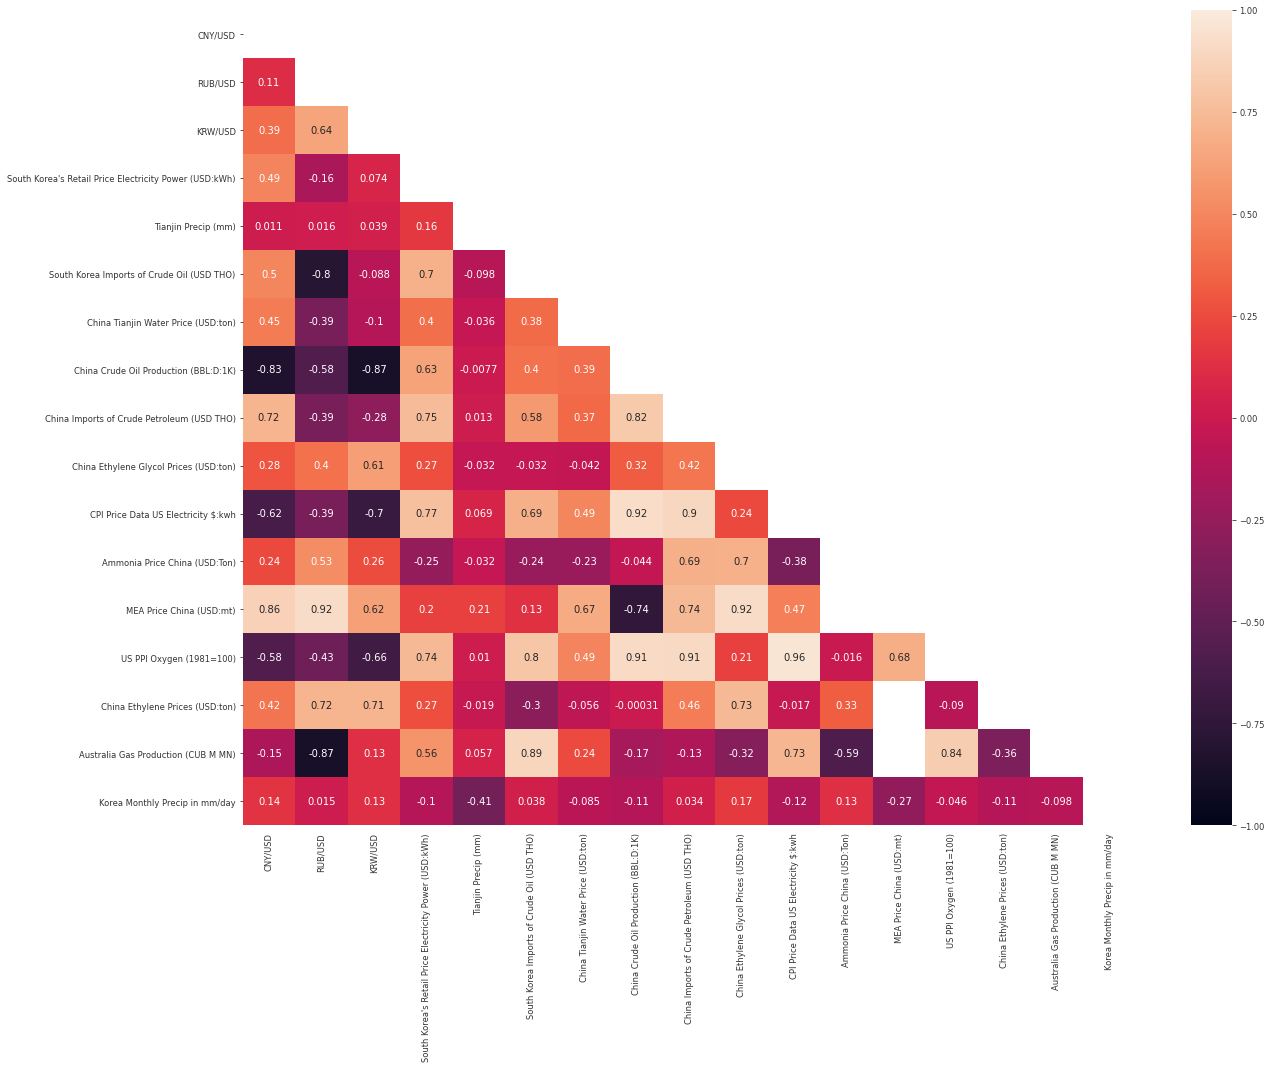

In [29]:
import seaborn as sn
import numpy as np

# plot heatmap
correlation = M.corr()
plt.subplots(figsize=(20,15))

mask = np.triu(np.ones_like(correlation, dtype=bool))

heatmap = sn.heatmap(correlation, mask=mask, vmin=-1, vmax=1, annot=True) #, cmap='BrBG')

#heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
#sns_plot = sn.heatmap(correlation, annot=True)

In [30]:
# Pickle data for easy access in the future

from help import pickle
pickle(M, 'dataframe')

In [31]:
# Make the matrix for linear regression of all variables


# make future array of dates
future_dates = [datetime(x, 12, 21) for x in range(2022, 2043)]
future = np.array([convert_date_to_number(x) for x in future_dates])



def linear(x, m, b):
    return m*x + b


linear_future = []


for name in M.columns:

    y_array = M[[name]].to_numpy().flatten()

    bool_array = np.isnan(y_array) == False

    y_array = y_array[bool_array]
    time_array = np.array([convert_date_to_number(x) for x in M.index[bool_array]])

    coefficients, pcov_linear = scipy.optimize.curve_fit(linear, time_array, y_array, p0=[0, 0])

    m, b = coefficients

    y_pred = linear(future, m, b)

    linear_future.append(pd.DataFrame(y_pred, columns=[name], index=future_dates))

# save to pickle
pickle(pd.concat(linear_future, axis = 1),'linear future')

In [34]:
def exponential(x, a, b):
    return a + np.exp(x*b)

exponential_future = []


for name in M.columns:

    y_array = M[[name]].to_numpy().flatten()

    bool_array = np.isnan(y_array) == False

    y_array = y_array[bool_array]
    time_array = np.array([convert_date_to_number(x) for x in M.index[bool_array]])

    coefficients, pcov_linear = scipy.optimize.curve_fit(exponential, time_array, y_array, p0=[0, 0])

    a, b = coefficients

    y_pred = exponential(future, a, b)

    exponential_future.append(pd.DataFrame(y_pred, columns=[name], index=future_dates))


pickle(pd.concat(exponential_future, axis = 1),'exponential future')

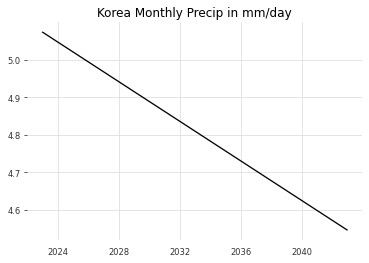

In [59]:
# save plots of future extrapolation

LF = pd.concat(linear_future, axis = 1)

for name in LF.columns:
    
    y = LF[[name]].to_numpy().flatten()
    x = LF.index

    plt.clf()
    plt.title(name.replace(':','/'))
    plt.plot(x, y, label = 'predicted') 

    plt.savefig(f'Linear Plots/{name.replace("/",":")}')

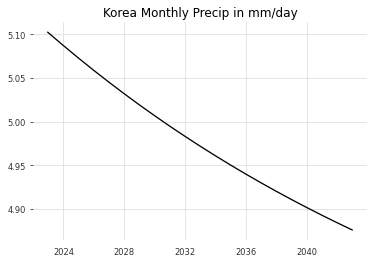

In [60]:

EF = pd.concat(exponential_future, axis = 1)

for name in EF.columns:
    
    y = EF[[name]].to_numpy().flatten()
    x = EF.index


    plt.clf()
    plt.title(name.replace(':','/'))
    plt.plot(x, y, label = 'predicted')

    plt.savefig(f'Exponential Plots/{name.replace("/",":")}')

In [ ]:
# TODO: extrapolate using facebook prophet